In [1]:
%config Completer.use_jedi = False
%matplotlib inline
import calendar
import datetime
import geopandas as gpd
import itertools
import libpysal
import mapclassify
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly_express as px
import seaborn as sns
import statsmodels.api as sm
import warnings
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
from matplotlib.pyplot import figure
from pandas import to_datetime
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from zipfile import ZipFile

In [2]:
pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_colwidth', None)

year_2014 = datetime.strptime('2014-3-15', '%Y-%m-%d')
year_2017 = datetime.strptime('2017-3-15', '%Y-%m-%d')
year_2019 = datetime.strptime('2019-3-15', '%Y-%m-%d')
year_2020 = datetime.strptime('2020-3-15', '%Y-%m-%d')
graph_end = datetime.strptime('2021-07-31', '%Y-%m-%d')

# Daily boarding totals
board_df = pd.read_csv('C://Users/Joseph/Documents/Jupyter/Daily_Boarding_Totals.csv',index_col='service_date',parse_dates=True)
board_df = board_df.drop(['day_type','rail_boardings','total_rides'],axis=1).rename(columns={'bus':'riders'})
board_df.index.names = ['date']
board_df = board_df.truncate(before=year_2014)
board_df.index.freq='D'

# Daily boarding totals by route
routes_df = pd.read_csv('C://Users/Joseph/Documents/Jupyter/Bus_Routes_Monthly_DayType_Averages_Totals.csv')
routes_df = routes_df.drop(["Avg_Weekday_Rides","Avg_Saturday_Rides","Avg_Sunday-Holiday_Rides"], axis=1)
routes_df = routes_df.rename(columns={'Month_Beginning': 'date', 'MonthTotal': 'riders'})
routes_df['date'] = pd.to_datetime(routes_df['date'])
routes_df = routes_df.set_index('date').truncate(before=year_2014).reset_index()
num_months = (graph_end.year - year_2014.year) * 12 + (graph_end.month - year_2020.month)
missing_val = routes_df.groupby(['route'], as_index=False).count()
missing_val.drop(missing_val[missing_val['riders'] >= num_months].index, inplace = True)
routes_df = routes_df.loc[~routes_df['route'].isin(missing_val['route'])]

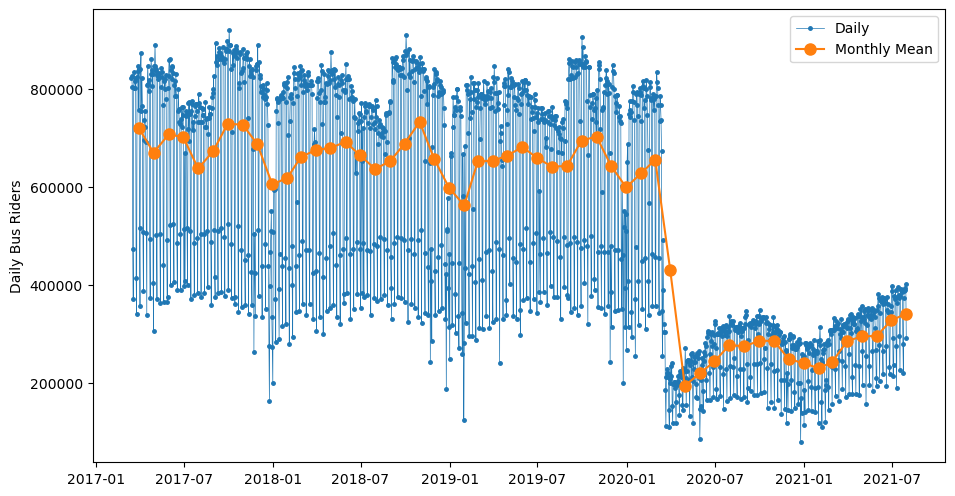

In [3]:
# Daily riders over a three-year pre-pandemic period and the pandemic period
def graph(y):
    fig, ax = plt.subplots(figsize=(11,6), dpi=100)
    ax.plot(y.truncate(before=year_2017),
            marker='.', markersize=5, linestyle='-', linewidth=0.5, label='Daily')
    ax.plot(y.truncate(before=year_2017).resample('M').mean(),
            marker='o', markersize=8, linestyle='-', label='Monthly Mean')
    ax.set_ylabel('Daily Bus Riders')
    ax.legend();
    
graph(board_df['riders'])

In [4]:
# Augmented Dickey-Fuller Test
def adf_test(y):
    print(' > Is the raw data stationary ?')
    print('Date range: ', y.index[0].date(), '-', y.index[-1].date())
    y = y['riders']
    dftest = adfuller(y.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {}stationary with {}% confidence'
              .format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
    
adf_test(board_df.truncate(after=year_2020))

# The data is stationary, therefore, additional decomposition is unneeded.

 > Is the raw data stationary ?
Date range:  2014-03-15 - 2020-03-15
Test statistic = -5.179
P-value = 0.000
Critical values :
	1%: -3.433372653139527 - The data is stationary with 99% confidence
	5%: -2.8628753016111688 - The data is stationary with 95% confidence
	10%: -2.567480848042739 - The data is stationary with 90% confidence


In [5]:
# fbprophet has a bug that spits out reams of print statements without this hotfix
# https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [6]:
def prophet_forecast(dataframe, pred_begin, frequency):
    train_begin = pred_begin-relativedelta(years=3)
    
    df = dataframe.reset_index()
    df.columns = ['ds', 'y']
    df['ds']= to_datetime(df['ds'])

    train = df.set_index('ds').truncate(before=train_begin, after=pred_begin).reset_index()

    if frequency == 'M' or frequency == 'MS':
        model = Prophet(yearly_seasonality=True,weekly_seasonality=False,daily_seasonality=False)
    else:
        model = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True)
        print('Training period:   ',train_begin.date(),' - ',pred_begin.date())
        print('Prediction period: ',pred_begin.date(),' - ',(pred_begin+relativedelta(years=1)).date())

    model.fit(train)

    pred = list()
    for date in pd.date_range(start=pred_begin, end=graph_end, freq=frequency):
        pred.append([date.strftime("%Y-%m-%d")])
    pred = pd.DataFrame(pred)
    pred.columns = ['ds']
    pred['ds'] = to_datetime(pred['ds'])

    forecast = model.predict(pred)
    
    return forecast, df


def mean_abs_error(forecast, df):
    mae = mean_absolute_error(df['y'][-len(forecast):].values,
                              forecast['yhat'].values)
    print('Mean Absolute Error: %.3f' % mae)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Mean Absolute %% Error:  %.3f' % mape)
    return

def graph_forecast(forecast, df):
    y_true = df.set_index('ds')
    y_pred = forecast[['ds','yhat']].set_index('ds').squeeze()
    fig, ax = plt.subplots(figsize=(11,6), dpi=100)
    y_true = y_true.squeeze()
    y_true = y_true.truncate(before=year_2017)
    ax.plot(y_true, marker='.', markersize=5, linestyle='-', linewidth=0.5, label='Actual')
    ax.plot(y_pred, linewidth=0.8, label='Predicted')
    ax.set_ylabel('Daily Bus Riders')
    ax.legend();

Training period:    2016-03-15  -  2019-03-15
Prediction period:  2019-03-15  -  2020-03-15
Mean Absolute Error: 54075.115
Mean Absolute % Error:  10.200


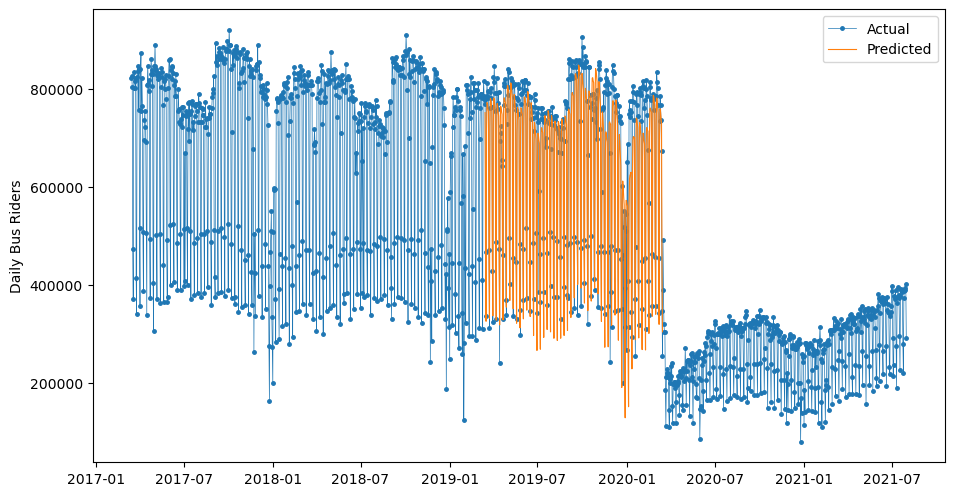

In [7]:
with suppress_stdout_stderr():
    forecast, returned_df = prophet_forecast(board_df.copy(),year_2019,'D')

forecast = forecast.set_index('ds').truncate(after=year_2020).reset_index()
y_true = returned_df.set_index('ds').truncate(before=year_2019,after=year_2020).reset_index()
mean_abs_error(forecast,y_true)
mean_absolute_percentage_error(forecast['yhat'],y_true['y'])
graph_forecast(forecast,returned_df)

Training period:    2017-03-15  -  2020-03-15
Prediction period:  2020-03-15  -  2021-03-15
Mean Absolute Error: 389303.463
Mean Absolute % Error:  58.019


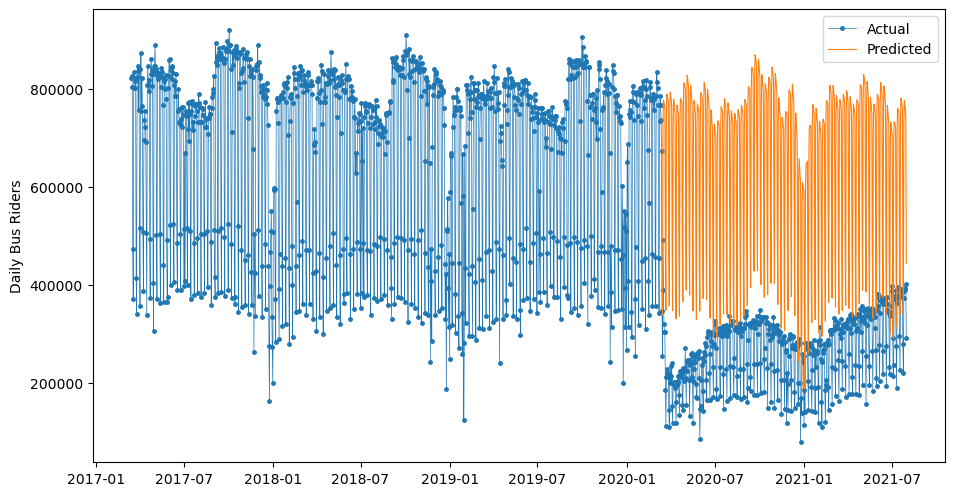

In [9]:
with suppress_stdout_stderr():
    forecast, returned_df = prophet_forecast(board_df.copy(),year_2020,'D')
    
y_true = returned_df.set_index('ds').truncate(before=year_2020).reset_index()
mean_abs_error(forecast,y_true)
mean_absolute_percentage_error(forecast['yhat'],y_true['y'])
graph_forecast(forecast,returned_df)

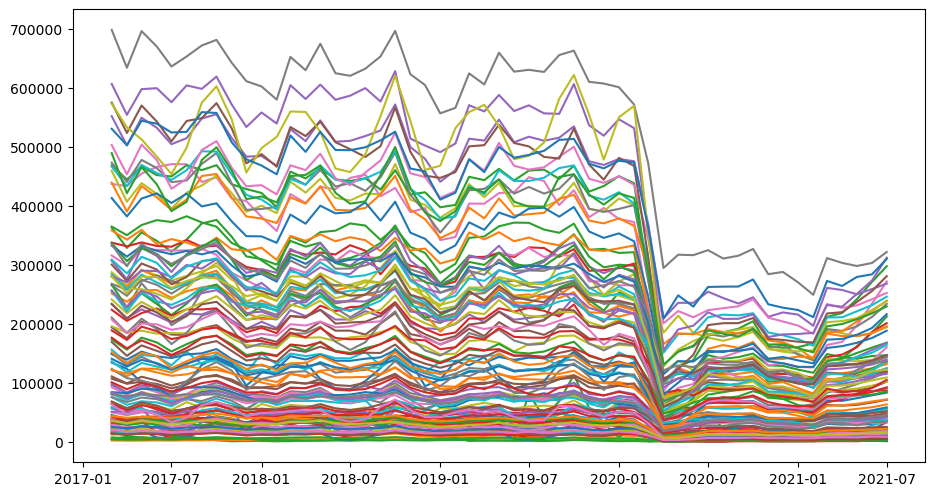

In [10]:
# Line graph of bus riders over time, by route
routes_graph = routes_df.set_index('date').truncate(before=year_2017-relativedelta(months=1))
routes_graph = routes_graph.reset_index().groupby('route')                
figure(figsize=(11,6), dpi=100)
for name, group in routes_graph:
    plt.plot(group['date'],group['riders'],label=name)

In [11]:
riders_by_route = routes_df.set_index('date')
route_diff = []


def percentage_change(col1, col2):
    return round(((col2 - col1) / col1) * 100)


def route_forecast(route_list):
    for i in route_list:
        route_loc = riders_by_route.loc[riders_by_route['route'] == i]
        routename = route_loc['routename'][0]
        forecast, returned_df = prophet_forecast(route_loc.drop(columns=['route','routename']),year_2020,'MS')

        forecast = forecast[['ds','yhat']].set_index('ds')
        returned_df = returned_df.iloc[-16:].set_index('ds')
        forecast = forecast.merge(returned_df, how='inner', left_index=True, right_index=True).sum()

        route_diff.append([i, routename, round(forecast['yhat']), round(forecast['y'])])

    routes_df2 = pd.DataFrame(route_diff, columns=['Route','Route Name','Predicted','Actual'])
    routes_df2['Rider % Change'] = percentage_change(routes_df2['Predicted'], routes_df2['Actual'])
    return routes_df2

route_df = route_forecast(sorted(routes_df['route'].unique()))
print(route_df.set_index('Route'))

                            Route Name  Predicted   Actual  Rider % Change
Route                                                                     
1            Bronzeville/Union Station     631917    73498           -88.0
100              Jeffery Manor Express     141013    72649           -48.0
1001       Shuttle/Special Event Route     958189   147103           -85.0
103                         West 103rd     787274   341008           -57.0
106                         East 103rd     430923   172862           -60.0
108                       Halsted/95th     268535   116561           -57.0
11                             Lincoln     625059   251067           -60.0
111                   111th/King Drive    1077417   549362           -49.0
111A                   Pullman Shuttle     127824    75020           -41.0
112                    Vincennes/111th     639979   263213           -59.0
115                      Pullman/115th    1114418   485579           -56.0
119                     M

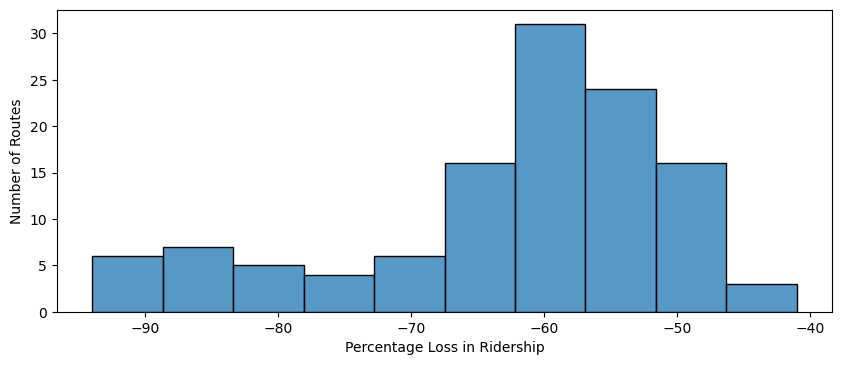

In [12]:
route_df['clusters'] = route_df['Rider % Change'].loc[route_df['Rider % Change'] < 0]

plt.figure(figsize=(10,4), dpi=100)
ax = sns.histplot(route_df['clusters'], kde=False)
ax.set(xlabel='Percentage Loss in Ridership', ylabel='Number of Routes')
plt.show()

In [13]:
kmz = ZipFile('C://Users/Joseph/Documents/Jupyter/CTA_BusRoutes.kmz', 'r')
kml = kmz.open('doc.kml', 'r')

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
gdf = gpd.read_file(kml, driver='KML')
gdf = gdf.rename(columns={'Name': 'Route'})
gdf = gdf.merge(route_df, on='Route', how='inner')#.set_index('Route').sort_index()
gdf = gpd.GeoDataFrame(gdf)

legend = mapclassify.Quantiles(gdf['Rider % Change'], k=5)
mapping = dict([(i,s) for i,s in enumerate(legend.get_legend_classes())])

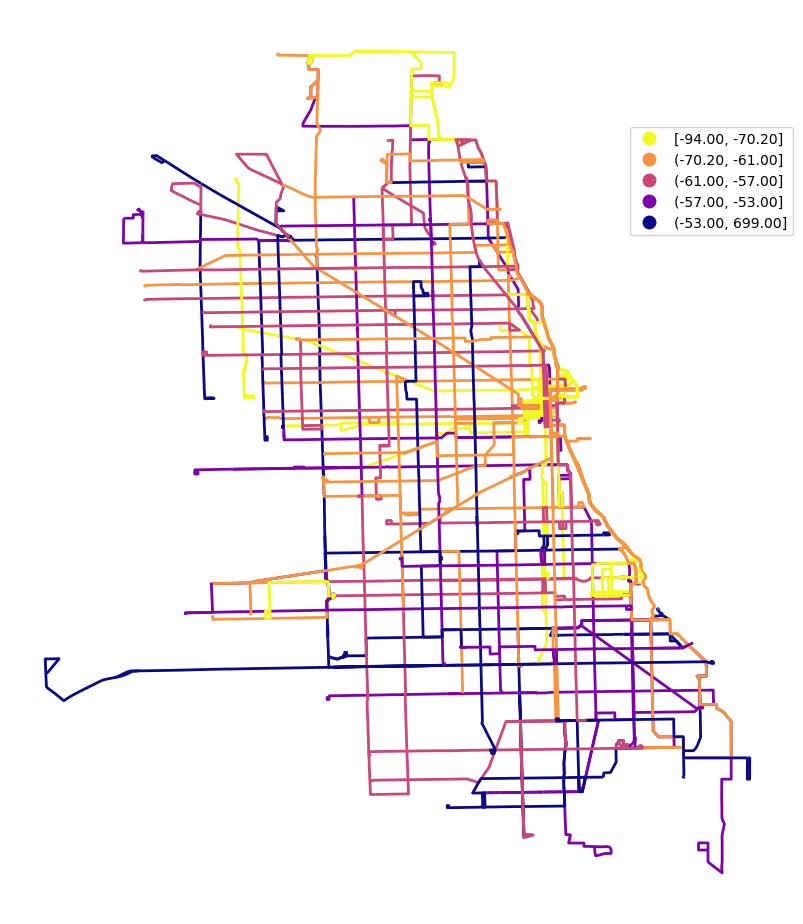

In [14]:
f, ax = plt.subplots(1, figsize=(10,16), dpi=100)
gdf.assign(cl=legend.yb).plot(column='cl', categorical=True, k=5, cmap='plasma_r', \
                           linewidth=2, ax=ax, legend=True, legend_kwds={'loc': (0.8,0.75)})
ax.set_axis_off()
texts = ax.get_legend().texts
for txt in texts:
    for k,v in mapping.items():
        if txt.get_text() == str(k):
            txt.set_text(v)
plt.show()